In [1]:
from NeuralNetwork import NeuralNetwork
import numpy as np
import random
from Board import Board
from Game import Game
import sys

In [2]:
game = Game()

In [3]:
#The valid actions array is an important input to the reinforcement learning model,
# as it constrains the set of actions that the model can choose from in each state.
# By specifying the valid actions array, you can ensure that the model only learns to
# choose actions that are valid in the current state of the game, and avoid actions that
# would result in an invalid game state.

# valid_actions = [left, right, CC, CW, drop]
valid_actions = [0, 1, 2, 3, 4] 

In [4]:
# Remember that we used ϵ to indicate the probability of taking a random action.
# Its value is from 0 to 1. Given a Q net, called Qnet, the current state,
# the set of valid_actions and epsilon, we can define a function that either returns
# a random choice from valid_actions or the best action determined by the values
# of Q produced by Qnet for the current state and all valid_actions. 
# This is referred to as an ϵ-greedy policy.

def epsilon_greedy(Qnet, state, valid_actions, epsilon):
    '''epsilon is between 0 and 1 and is the probability of returning a random action'''
    valid_actions = game.getValidActions()
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(valid_actions)
        
    else:
        # Greedy Move
        actions_randomly_ordered = random.sample(valid_actions, len(valid_actions))
        Qs = [Qnet.use(np.array(state)) for a in actions_randomly_ordered]
        ai = np.argmax(Qs)
        action = actions_randomly_ordered[ai]
        
    Q = Qnet.use(np.array(state))
    
    return action, Q   # return the chosen action and Q(state, action)

In [5]:
# Initial state should return board state and initial piece state
def initial_state():   
    return game.getBoard(), game.getPiece() 

# Next state needs to be the previous frame altered by the action
def next_state(s, a):
    return game.getNextFrame(s, a)

def reinf(s, sn):  # sn is next state
    return game.getReinforcements(s, sn)

In [6]:
# Now we need a function, make_samples, for collecting a bunch of samples of state,
# action, reinforcement, next state, next actions. We can make this function generic by passing
# in functions to create the initial state, the next state, and the reinforcement value.

def make_samples(Qnet, initial_state_f, next_state_f, reinforcement_f,
                 valid_actions, n_samples, epsilon):

    X = np.zeros((n_samples, Qnet.n_inputs))
    print(X.shape)
    R = np.zeros((n_samples, 1))
    Qn = np.zeros((n_samples, 1))

    s = initial_state_f()
    # TODO: Need to expand the state when passed to epsilon_greedy too
    expanded_state = expand_state(s)
    a, _ = epsilon_greedy(Qnet, expanded_state, valid_actions, epsilon)

    # Collect data from n_samples steps
    for step in range(n_samples):
        
        next_state = next_state_f(s, a)        # Update state, sn, from s and a
        sn = next_state[:2]
        will_lock = next_state[2]
        if will_lock:
            game.lockPiece()
            break
        rn = reinforcement_f(s, sn)    # Calculate resulting reinforcement
        an, qn = epsilon_greedy(Qnet, expand_state(sn), valid_actions, epsilon)  # choose next action
        print(an)
        X[step, :] = expand_state(s)
        R[step, 0] = rn
        Qn[step, 0] = qn
        s, a = sn, an  # Advance one time step
        
        game.getBoard().showBoard(game.getPiece())

    return (X, R, Qn)

def expand_state(s):
    board, piece = s
    # Every square on the board has a 0 if empty or 1 if filled. So we take each column, make a binary string from
    # top to bottom, and convert to decimal to create the inputs to the NN. This is great because no information
    # is lost about the column, and you can determine whether a column is higher than another just by comparing
    # the value. Hopefully This will help to preserve patterns
    decimal_columns = [int(''.join([str(int(item)) for item in row]), 2) for row in board.board.T]
    flat_piece_points = np.reshape([[point.x,point.y] for point in piece.getCurrentPoints()], 8)
    return np.hstack((decimal_columns, flat_piece_points))

(18,)
GOAL


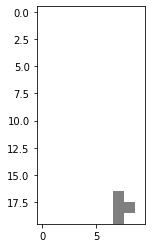

(20, 18)
2


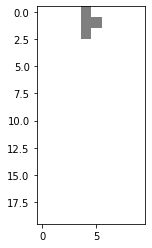

4


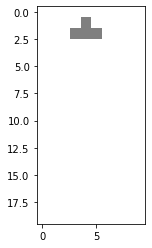

1


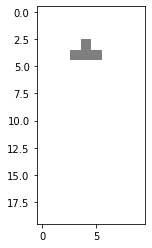

3


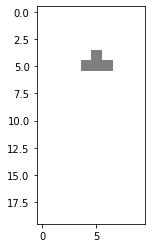

2


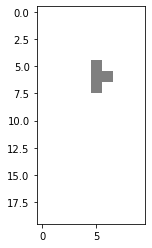

0


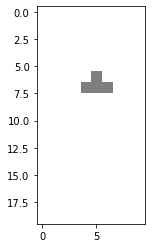

1


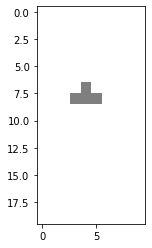

2


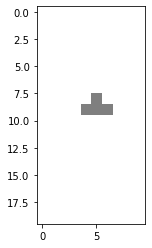

3


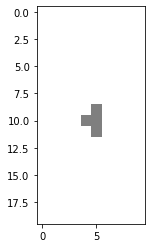

0


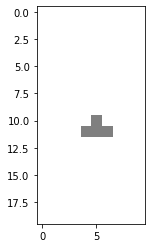

2


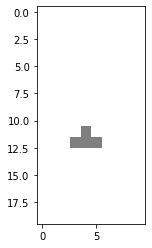

0


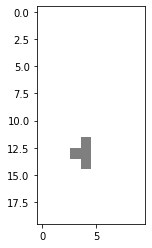

4


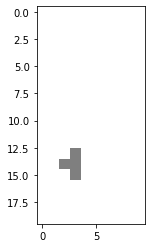

1


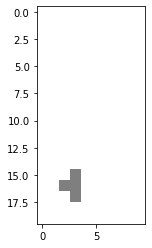

2


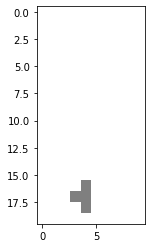

4


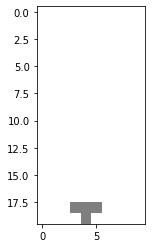

Adam: Epoch 2 Error=1.55952
Adam: Epoch 4 Error=0.58227
Adam: Epoch 6 Error=0.53447
Adam: Epoch 8 Error=0.92722
Adam: Epoch 10 Error=0.97508
Adam: Epoch 12 Error=0.76737
Adam: Epoch 14 Error=0.47127
Adam: Epoch 16 Error=0.35184
Adam: Epoch 18 Error=0.49876
Adam: Epoch 20 Error=0.60820
END


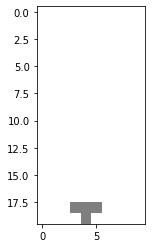

GOAL


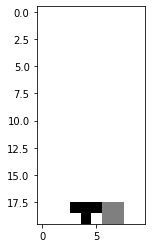

(20, 18)
3


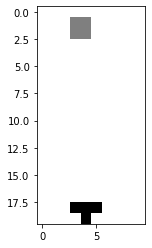

0


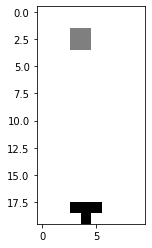

4


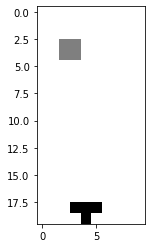

0


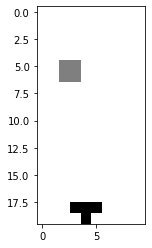

0


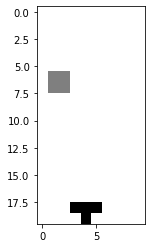

3


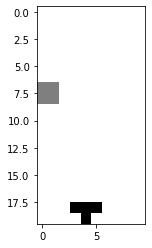

2


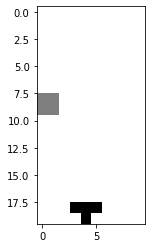

1


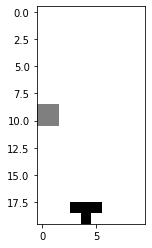

4


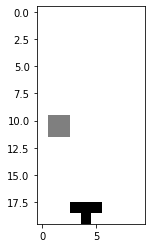

2


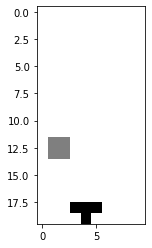

1


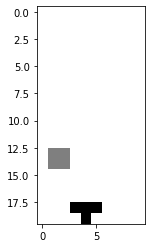

3


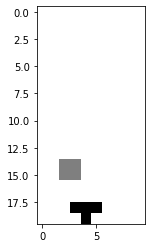

2


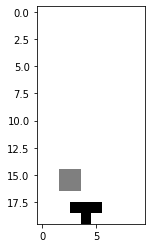

4


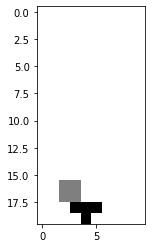

Adam: Epoch 2 Error=1.24224
Adam: Epoch 4 Error=0.87062
Adam: Epoch 6 Error=1.07674
Adam: Epoch 8 Error=1.12114
Adam: Epoch 10 Error=0.97838
Adam: Epoch 12 Error=0.86808
Adam: Epoch 14 Error=0.90079
Adam: Epoch 16 Error=0.95821
Adam: Epoch 18 Error=0.93727
Adam: Epoch 20 Error=0.86673
END


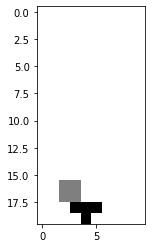

In [7]:
# Instantiating Initial Parameters
n_trials = 2
n_steps_per_trial = 20
n_epochs = 20
learning_rate = 0.01
n_hidden = [50]
gamma = 0.8
final_epsilon = 0.0001  
epsilon = 1.0
epsilon_decay = np.exp(np.log(final_epsilon) / n_trials)

# Instantiate Neural Network
Qnet = NeuralNetwork(18, n_hidden, 1)

# We need to set standardization parameters now so Qnet can be called to get first set of samples,
# before it has been trained the first time.

def setup_standardization(Qnet, Xmeans, Xstds, Tmeans, Tstds):
    Qnet.Xmeans = np.array(Xmeans)
    Qnet.Xstds = np.array(Xstds)
    Qnet.Tmeans = np.array(Tmeans)
    Qnet.Tstds = np.array(Tstds)

# Inputs are position (1 to 10) and action (-1, 0, or 1)
Xmeans = [np.mean(np.arange(0,2**19-1))] * 10
Xmeans.extend([np.mean(np.arange(0,10)), np.mean(np.arange(0,20))] * 4)
Xstds = [np.std(np.arange(0,2**19-1))] * 10
Xstds.extend([np.std(np.arange(0,10)), np.std(np.arange(0,20))] * 4)
setup_standardization(Qnet, Xmeans, Xstds, [5], [1])
print(Qnet.Xmeans.shape)

x_trace = np.zeros((n_trials * n_steps_per_trial, 18))
r_trace = np.zeros((n_trials * n_steps_per_trial, 1))
error_trace = []
epsilon_trace = np.zeros((n_trials, 1))

for trial in range(n_trials):
    print("GOAL")
    game.getBoard().showBoard(game.goalPiece)
    
    X, R, Qn = make_samples(Qnet, initial_state, next_state, reinf, valid_actions, n_steps_per_trial, epsilon)
 
    T = R + gamma * Qn
    Qnet.train(X, T, n_epochs, learning_rate, method='adam')
    
    epsilon_trace[trial] = epsilon
    i = trial * n_steps_per_trial
    j = i + n_steps_per_trial
    x_trace[i:j, :] = X
    r_trace[i:j, :] = R
    error_trace += Qnet.error_trace

    print("END")
    game.getBoard().showBoard(game.getPiece())
    
    game.nextPiece()